In [ ]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#hide
# from nbdev.showdoc import *
# from fastai.vision import *
import numpy as np
import torch
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import viz, cameras
from pathlib import Path
from pprint import pprint
import json
import cv2
import matplotlib.image as mpimg

In [ ]:
data_path = Path('data')
# data_path.ls()

In [ ]:
def unnormalize(normalized, mean, std, dim_ignore):
    T = normalized.shape[0]
    D = mean.shape[0]
    orig = np.zeros((T, D), dtype=np.float32)
    dim_use = np.array([dim for dim in range(D) if dim not in dim_ignore])
    orig[:, dim_use] = normalized
    
    std_m = std.reshape((1, D))
    std_m = np.repeat(std_m, T, axis=0)
    mean_m = mean.reshape((1, D))
    mean_m = np.repeat(mean_m, T, axis=0)
    orig = np.multiply(orig, std_m) + mean_m
    return orig

In [ ]:
stat_3d = torch.load(data_path/'stat_3d.pth.tar')
stat_3d.keys()

dict_keys(['mean', 'std', 'dim_use', 'dim_ignore', 'train_root', 'test_root'])

In [ ]:
stat_2d = torch.load(data_path/'stat_2d.pth.tar')
stat_2d.keys()

dict_keys(['mean', 'std', 'dim_ignore', 'dim_use'])

In [ ]:
test_set_3d = torch.load(data_path/'test_3d.pth.tar')
train_set_3d = torch.load(data_path/'train_3d.pth.tar')

In [ ]:
test_set_2d = torch.load(data_path/'test_2d.pth.tar')
train_set_2d = torch.load(data_path/'train_2d.pth.tar')

In [ ]:
rcams = torch.load(data_path/'rcams.pth.tar')

In [ ]:
test_2d = 0
test_3d = 0
for key2d in test_set_2d.keys():
    test_2d += test_set_2d[key2d].shape[0]
    test_3d += test_set_3d[key2d].shape[0]
train_2d = 0
train_3d = 0
for key2d in train_set_2d.keys():
    train_2d += train_set_2d[key2d].shape[0]
    train_3d += train_set_3d[key2d].shape[0]
print(test_2d, test_3d, train_2d, train_3d)

550644 550644 1559752 1559752


In [ ]:
N_CAMERAS = 4
N_JOINTS  = 32

In [ ]:
def get_cam_rt(key):
    subj, _, sname = key
    cname = sname.split('.')[1] # <-- camera name
    scams = {(subj,c+1): rcams[(subj,c+1)] for c in range(N_CAMERAS)} # cams of this subject
    scam_idx = [scams[(subj,c+1)][-1] for c in range(N_CAMERAS)].index( cname ) # index of camera used
    the_cam  = scams[(subj, scam_idx+1)] # <-- the camera used
    R, T, f, c, k, p, name = the_cam
    assert name == cname    
    return R, T
    
def cam_world(data, key):
    R, T = get_cam_rt(key)
    data_3d_worldframe = cameras.camera_to_world_frame(data.reshape((-1, 3)), R, T)
    data_3d_worldframe = data_3d_worldframe.reshape((-1, N_JOINTS*3))
    # subtract root translation
    return data_3d_worldframe - np.tile( data_3d_worldframe[:,:3], (1,N_JOINTS) )

In [ ]:
key_list = list(test_set_2d.keys())
# pprint(key_list)

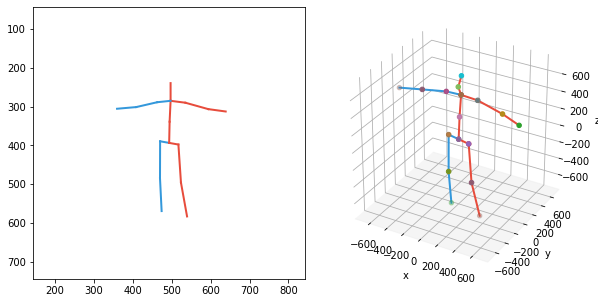

In [ ]:
key0 = (9, 'Directions', 'Directions 1.54138969.h5')
key1 = (9, 'Directions', 'Directions 1.55011271.h5')
key2 = (9, 'Directions', 'Directions 1.58860488.h5')
key3 = (9, 'Directions', 'Directions 1.60457274.h5')
key = key1

idx = 1
# xx = test_set_2d[key][idx]
xx = np.array([ 
    [
     -0.36024637, -0.4107207 , # hip
     -0.51964641, -0.44753023, # rhip
     -0.51208356, -0.17149943, # rknee
     -0.46021477, -0.11819434, # rfoot
     -0.14993079, -0.37074958, # lhip
     -0.07848403,  0.0276426,  # lknee
      0.08809774,  0.07604583, # lfoot
     -0.35328366, -0.45885561, # spine
     -0.33440129, -0.43458056, # thorax
     -0.3352825 , -0.53266324, # head
     0.00710702, -0.54450953,  # lshoulder
     0.56348499, -0.94065232,  # lelbow
      0.97341037, -0.94695775, # lwrist
     -0.58346909, -0.5542243 , # rshoulder
     -0.9222964 , -0.93881767, # relbow
     -1.31640753, -0.8329202   # rwrist
    ] ])

xx = xx.reshape(1, -1)
xx = unnormalize(xx, stat_2d['mean'], stat_2d['std'], stat_2d['dim_ignore'])

yy = test_set_3d[key][idx]
yy = yy.reshape(1, -1)
yy = unnormalize(yy, stat_3d['mean'], stat_3d['std'], stat_3d['dim_ignore'])
yy = cam_world(yy, key)

fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2)
gs.update(wspace=0.05, hspace=0.05)
ax1 = plt.subplot(gs[0])
viz.show2Dpose(xx, ax1)
ax1.invert_yaxis()

ax2 = plt.subplot(gs[1], projection='3d')
viz.show3Dpose(yy, ax2, add_labels=True)

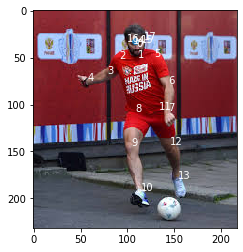

In [ ]:
with open("keypoints.json") as f:
    kp = json.load(f)
kpl = np.array(kp['people'][0]['pose_keypoints_2d']).reshape(-1, 2)
img = mpimg.imread('p1.jpg')
plt.imshow(img)

for i,(x,y) in enumerate(kpl):
#     plt.scatter(x,y)
    plt.text(x,y, i, c='white')
# plt.savefig('keypoint.jpg')
plt.scatter(108.5, 32)
plt.show()

In [ ]:
def coco2skel(s):
    s = s.reshape(-1, 2)
    hip = (s[8] + s[11]) / 2
    rhip = s[8]
    rknee = s[9]
    rfoot = s[10]
    lhip = s[11]
    lknee = s[12]
    lfoot = s[13]
    spine = (s[1] + hip) / 2
    thorax = s[1]
    head = (s[16] + s[17]) / 2 # TODO:  kurang tinggi
    lshoulder = s[5]
    lelbow = s[6]
    lwrist = s[7]
    rshoulder = s[2]
    relbow = s[3]
    rwrist = s[4]
    return np.array([hip, rhip, rknee, rfoot, lhip, lknee, lfoot, 
            spine, thorax, head, 
            lshoulder, lelbow, lwrist,
            rshoulder, relbow, rwrist ]).reshape(1, -1)

skel = coco2skel(np.array(kp['people'][0]['pose_keypoints_2d'])) * 3

In [ ]:
def normalize(unnormalized, mean, std, dim_use):
    normalized = {}
    for key in unnormalized.keys():
        unnormalized[key] = unnormalized[key][:, dim_use]
        m = mean[dim_use]
        s = std[dim_use]
        normalized[key] = np.divide((unnormalized[key] - m), s)
    return normalized

In [ ]:
m = stat_2d['mean'][stat_2d['dim_use']]
s = stat_2d['std'][stat_2d['dim_use']]
skel_norm = np.divide((skel - m), s)
skel_norm

array([[-1.55549578e+00, -1.58211521e+00, -1.72096757e+00,
        -1.47003188e+00, -1.83577069e+00, -1.21774738e+00,
        -1.55342840e+00,  6.29869321e-04, -1.27796253e+00,
        -1.68984064e+00, -9.12385797e-01, -1.35755939e+00,
        -6.24333910e-01, -7.68775053e-01, -1.68864719e+00,
        -1.97807095e+00, -1.80852363e+00, -2.24251326e+00,
        -1.84917358e+00, -2.33159792e+00, -1.39160635e+00,
        -2.49913651e+00, -9.48423610e-01, -1.92439968e+00,
        -9.67763747e-01, -8.84991335e-01, -2.14236290e+00,
        -2.38489501e+00, -2.22197133e+00, -2.23525662e+00,
        -2.72176118e+00, -1.76500589e+00]])

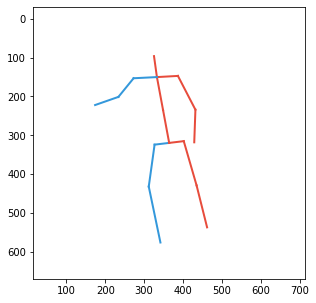

In [ ]:
skel_norm = unnormalize(skel_norm, stat_2d['mean'], stat_2d['std'], stat_2d['dim_ignore'])
fig = plt.figure(figsize=(10, 5))
gs = GridSpec(1, 2)
gs.update(wspace=0.05, hspace=0.05)
ax1 = plt.subplot(gs[0])
viz.show2Dpose(skel_norm, ax1)
ax1.invert_yaxis()

In [ ]:
skel_norm

array([[364.50000434, 319.50000243, 327.00000423, 324.00000123,
        311.99999545, 432.00000259, 341.99999829, 576.        ,
        529.33571189, 587.23551966, 529.38636921, 586.31801763,
        401.9999964 , 314.99999774, 434.99999742, 428.99999725,
        461.99999909, 537.00000037, 530.10512031, 587.89823506,
        530.49446311, 585.47494165, 532.0838752 , 419.7215386 ,
        348.75000434, 234.74999848, 332.99999774, 150.00000597,
        534.55416815, 304.241439  , 325.50000431,  95.99999051,
        534.11018559, 317.90342311, 387.00000229, 147.00000489,
        431.99999845, 233.99999602, 429.00000269, 317.9999989 ,
        533.49380106, 391.72324561, 533.62895965, 384.3068672 ,
        533.64435106, 394.59252866, 533.64435106, 394.59252866,
        534.11018559, 317.90342311, 273.00000771, 152.99999432,
        234.00000806, 200.99999607, 173.99999409, 221.99999499,
        532.72786934, 380.61615719, 532.89670133, 373.03286202,
        532.78290105, 381.24448162, 532.